In [15]:
import supermarq 
from __future__ import annotations
import cirq
#import qiskit
from qiskit.quantum_info import hellinger_fidelity
from supermarq.benchmark import Benchmark
from qiskit import transpile, QuantumCircuit
import qiskit.quantum_info as qi
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, amplitude_damping_error
from qiskit.tools.visualization import plot_histogram

In [16]:
#---------------Plain qft code starts--------------------
from concurrent.futures import ThreadPoolExecutor
from qiskit import *
from time import *
import numpy as np
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        #circuit.cu1(np.pi/2**(n-qubit), qubit, n)
        circuit.cp(np.pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

n=5
qc= QuantumCircuit(n,n)
qft(qc,n)
qc.measure_all()

In [17]:
qc.draw()

»
   q_0: ──────■─────────────────────────────────────────■────────────────»
              │                                         │                »
   q_1: ──────┼─────────■───────────────────────────────┼────────■───────»
              │         │                               │        │       »
   q_2: ──────┼─────────┼────────■──────────────────────┼────────┼───────»
              │         │        │                ┌───┐ │P(π/8)  │P(π/4) »
   q_3: ──────┼─────────┼────────┼────────■───────┤ H ├─■────────■───────»
        ┌───┐ │P(π/16)  │P(π/8)  │P(π/4)  │P(π/2) └───┘                  »
   q_4: ┤ H ├─■─────────■────────■────────■──────────────────────────────»
        └───┘                                                            »
   c: 5/═════════════════════════════════════════════════════════════════»
                                                                         »
meas: 5/═════════════════════════════════════════════════════════════════»
                                                                         »
«                                                      ┌───┐    ░ ┌─┐         »
«   q_0: ───────────────■──────────────────────■───────┤ H ├─X──░─┤M├─────────»
«                       │                ┌───┐ │P(π/2) └───┘ │  ░ └╥┘┌─┐      »
«   q_1: ───────────────┼────────■───────┤ H ├─■─────────X───┼──░──╫─┤M├──────»
«                 ┌───┐ │P(π/4)  │P(π/2) └───┘           │   │  ░  ║ └╥┘┌─┐   »
«   q_2: ─■───────┤ H ├─■────────■───────────────────────┼───┼──░──╫──╫─┤M├───»
«         │P(π/2) └───┘                                  │   │  ░  ║  ║ └╥┘┌─┐»
«   q_3: ─■──────────────────────────────────────────────X───┼──░──╫──╫──╫─┤M├»
«                                                            │  ░  ║  ║  ║ └╥┘»
«   q_4: ────────────────────────────────────────────────────X──░──╫──╫──╫──╫─»
«                                                               ░  ║  ║  ║  ║ »
«   c: 5/══════════════════════════════════════════════════════════╬══╬══╬══╬═»
«                                                                  ║  ║  ║  ║ »
«meas: 5/══════════════════════════════════════════════════════════╩══╩══╩══╩═»
«                                                                  0  1  2  3 »
«           
«   q_0: ───
«           
«   q_1: ───
«           
«   q_2: ───
«           
«   q_3: ───
«        ┌─┐
«   q_4: ┤M├
«        └╥┘
«   c: 5/═╬═
«         ║ 
«meas: 5/═╩═
«         4

In [18]:
ghz_features = [
    supermarq.converters.compute_communication_with_qiskit(qc),
    supermarq.converters.compute_depth_with_qiskit(qc),
    supermarq.converters.compute_entanglement_with_qiskit(qc),
    supermarq.converters.compute_liveness_with_qiskit(qc),
    supermarq.converters.compute_measurement_with_qiskit(qc),
    supermarq.converters.compute_parallelism_with_qiskit(qc),
]
print(ghz_features)

[1.0, 0.9166666666666666, 0.7058823529411765, 0.4, 0.0, 0.015625]


In [19]:
ghz_circuit = supermarq.ghz.GHZ(10).qiskit_circuit()
ghz_features = [
    supermarq.converters.compute_communication_with_qiskit(ghz_circuit),
    supermarq.converters.compute_depth_with_qiskit(ghz_circuit),
    supermarq.converters.compute_entanglement_with_qiskit(ghz_circuit),
    supermarq.converters.compute_liveness_with_qiskit(ghz_circuit),
    supermarq.converters.compute_measurement_with_qiskit(ghz_circuit),
    supermarq.converters.compute_parallelism_with_qiskit(ghz_circuit),
]
print(ghz_features)

[0.2, 1.0, 0.9, 0.2636363636363636, 0.0, 0.0]


In [20]:
ghz_circuit.draw()

┌───┐                                             
q_0: ┤ H ├──■──────────────────────────────────────────
     └───┘┌─┴─┐                                        
q_1: ─────┤ X ├──■─────────────────────────────────────
          └───┘┌─┴─┐                                   
q_2: ──────────┤ X ├──■────────────────────────────────
               └───┘┌─┴─┐                              
q_3: ───────────────┤ X ├──■───────────────────────────
                    └───┘┌─┴─┐                         
q_4: ────────────────────┤ X ├──■──────────────────────
                         └───┘┌─┴─┐                    
q_5: ─────────────────────────┤ X ├──■─────────────────
                              └───┘┌─┴─┐               
q_6: ──────────────────────────────┤ X ├──■────────────
                                   └───┘┌─┴─┐          
q_7: ───────────────────────────────────┤ X ├──■───────
                                        └───┘┌─┴─┐     
q_8: ────────────────────────────────────────┤ X ├──■──
                                             └───┘┌─┴─┐
q_9: ─────────────────────────────────────────────┤ X ├
                                                  └───┘

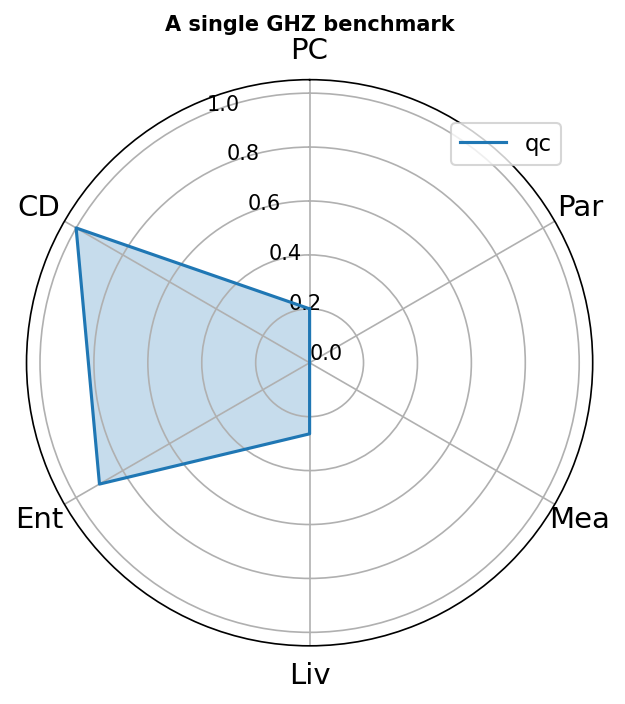

In [21]:
supermarq.plotting.plot_benchmark(
    ["A single GHZ benchmark", ["qc"], [ghz_features]],
    spoke_labels=["PC", "CD", "Ent", "Liv", "Mea", "Par"],
)

In [22]:
benchmark_features = {}
benchmarks = [
    (supermarq.ghz.GHZ(5), "qc"),
]
for benchmark, label in benchmarks:
    benchmark_features[label] = [
        supermarq.converters.compute_communication_with_qiskit(benchmark.qiskit_circuit()),
        supermarq.converters.compute_depth_with_qiskit(benchmark.qiskit_circuit()),
        supermarq.converters.compute_entanglement_with_qiskit(benchmark.qiskit_circuit()),
        supermarq.converters.compute_liveness_with_qiskit(benchmark.qiskit_circuit()),
        supermarq.converters.compute_measurement_with_qiskit(benchmark.qiskit_circuit()),
        supermarq.converters.compute_parallelism_with_qiskit(benchmark.qiskit_circuit()),
    ]
print(benchmark_features)

{'qc': [0.4, 1.0, 0.8, 0.4666666666666667, 0.0, 0]}


In [23]:
emulator = Aer.get_backend('aer_simulator_statevector')
job = execute(transpile(qc, emulator), emulator, shots=8192, memory=True)
job

In [24]:
#results = approximate_quantum_error(error, operator_string="reset")
emulator = Aer.get_backend('aer_simulator_density_matrix')
qc = transpile(qc, emulator)
job = execute(transpile(qc, emulator), emulator, shots=8192, memory=True)
qc.draw()
data=job.result()
print(data)

Result(backend_name='aer_simulator', backend_version='0.13.0', qobj_id='', job_id='e8d10bc5-3833-4b94-b433-b16a5d777f69', success=True, results=[ExperimentResult(shots=8192, success=True, meas_level=2, data=ExperimentResultData(), header=QobjExperimentHeader(creg_sizes=[['c', 5]], global_phase=0.0, memory_slots=5, n_qubits=5, name='circuit-176', qreg_sizes=[['q', 5]], metadata={}), status=DONE, seed_simulator=1470784430, metadata={'time_taken': 1.706e-05, 'num_bind_params': 1, 'required_memory_mb': 1, 'input_qubit_map': [], 'method': 'density_matrix', 'device': 'CPU', 'num_qubits': 0, 'parallel_state_update': 24, 'active_input_qubits': [], 'num_clbits': 5, 'remapped_qubits': False, 'parallel_shots': 1, 'runtime_parameter_bind': False, 'max_memory_mb': 63964, 'measure_sampling': False, 'batched_shots_optimization': False}, time_taken=1.706e-05)], date=2024-06-19T17:20:09.330825, status=COMPLETED, header=None, metadata={'time_taken_parameter_binding': 3.92e-06, 'time_taken_execute': 3.19

In [11]:
counts = job.result().get_counts()
print(counts)

QiskitError: 'No counts for experiment "0"'

In [13]:
jobs = []
backend = Aer.get_backend('aer_simulator_statevector')
for benchmark, label in benchmarks:
    job = backend.run(qc, shots=1000)
    jobs.append((label, job, benchmark))
ghz_circuit

In [14]:
data=job.result()
print(data)

Result(backend_name='aer_simulator', backend_version='0.13.0', qobj_id='', job_id='33a07223-8bb7-480e-99d6-5f57e8da1c12', success=True, results=[ExperimentResult(shots=1000, success=True, meas_level=2, data=ExperimentResultData(), header=QobjExperimentHeader(creg_sizes=[['c', 5]], global_phase=0.0, memory_slots=5, n_qubits=5, name='circuit-158', qreg_sizes=[['q', 5]], metadata={}), status=DONE, seed_simulator=1122550585, metadata={'time_taken': 2.2017e-05, 'num_bind_params': 1, 'required_memory_mb': 1, 'input_qubit_map': [], 'method': 'statevector', 'device': 'CPU', 'num_qubits': 0, 'parallel_state_update': 24, 'active_input_qubits': [], 'num_clbits': 5, 'remapped_qubits': False, 'parallel_shots': 1, 'runtime_parameter_bind': False, 'max_memory_mb': 63964, 'measure_sampling': False, 'batched_shots_optimization': False}, time_taken=2.2017e-05)], date=2024-06-19T15:46:05.793638, status=COMPLETED, header=None, metadata={'time_taken_parameter_binding': 5.416e-06, 'time_taken_execute': 4.09

In [ ]:
#---------method-2-----------
job = execute(simulation_circuits, backend, shots=shots) 